# Análisis de Componentes Principales (PCA)

## Justificación de la Técnica

### ¿Por qué aplicar PCA a este dataset?

En el análisis exploratorio previo identificamos varios problemas que PCA puede resolver:

1. **Alta correlación entre variables climáticas**:
   - Temperature(F) y Wind_Chill(F) tienen correlación r = 0.99 (casi perfecta)
   - Humedad correlaciona negativamente con Temperatura (-0.33) y Visibilidad (-0.38)
   - Estas redundancias dificultan la interpretación y pueden causar multicolinealidad en modelos

2. **Múltiples variables de infraestructura vial**:
   - 13 variables binarias (Amenity, Bump, Crossing, Junction, Traffic_Signal, etc.)
   - Posibles patrones subyacentes de "tipo de zona urbana" o "densidad de infraestructura"

3. **Dificultad para visualizar relaciones en alta dimensión**:
   - Con 20+ variables numéricas, es imposible visualizar todas las relaciones simultáneamente
   - PCA permite proyectar datos en 2D/3D manteniendo la mayor varianza posible

### Objetivos Específicos

1. **Reducir dimensionalidad** de variables climáticas manteniendo >90% de la varianza
2. **Identificar componentes principales** que capturen patrones latentes en infraestructura vial
3. **Visualizar** datos de alta dimensión en 2D para detectar grupos o patrones
4. **Preparar features** para modelos predictivos eliminando multicolinealidad

### Relación con las Preguntas de Investigación

- **Pregunta 1** (Factores ambientales y severidad): PCA reducirá variables climáticas correlacionadas en componentes interpretables
- **Pregunta 3** (Variación entre estados): PCA permitirá visualizar diferencias regionales en un espacio reducido

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

print("Librerías importadas correctamente ✓")

Librerías importadas correctamente ✓


## 1. Carga de Datos Preprocesados

Utilizamos el dataset limpio generado en `data_preprocessing.ipynb`, que ya tiene:
- Valores faltantes imputados
- Tipos de datos correctos
- Variables temporales derivadas (hora, mes, año, categoría de tiempo)
- Registros inválidos filtrados

In [2]:
# Cargar dataset limpio
data_path = Path("accidents_clean.csv")
df = pd.read_csv(data_path)

print(f"Dataset cargado: {df.shape[0]:,} registros, {df.shape[1]} variables")
print(f"\nPrimeras columnas:")
df.head(3)

Dataset cargado: 6,979,296 registros, 50 variables

Primeras columnas:


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,duration_min,start_hour,start_dow,start_month,start_year,time_category
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865,-84.059,0.010,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.900,62.000,91.000,29.680,10.000,Calm,7.000,0.020,Light Rain,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Night,Night,Night,314.000,5,0,2,2016,Madrugada
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928,-82.831,0.010,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.900,62.000,100.000,29.650,10.000,Calm,7.000,0.000,Light Rain,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Night,Night,Day,30.000,6,0,2,2016,Mañana
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063,-84.033,0.010,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.000,33.300,100.000,29.670,10.000,SW,3.500,0.000,Overcast,0,0,0,0,0,0,0,0,0,0,0,1,0,Night,Night,Day,Day,30.000,6,0,2,2016,Mañana


## 2. PCA sobre Variables Climáticas

### Objetivo
Reducir las 7 variables climáticas (altamente correlacionadas) a 2-3 componentes principales que capturen la mayor varianza posible.

### Variables seleccionadas
- Temperature(F)
- Wind_Chill(F) - correlación 0.99 con Temperature
- Humidity(%)
- Pressure(in)
- Visibility(mi)
- Wind_Speed(mph)
- Precipitation(in)

In [3]:
# Seleccionar variables climáticas numéricas
climate_vars = [
    'Temperature(F)',
    'Wind_Chill(F)',
    'Humidity(%)',
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Precipitation(in)'
]

# Extraer datos y eliminar filas con valores faltantes
X_climate = df[climate_vars].dropna()

print(f"Dimensión original: {X_climate.shape}")
print(f"\nEstadísticas descriptivas:")
X_climate.describe()

Dimensión original: (6979296, 7)

Estadísticas descriptivas:


,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,6979296.000,6979296.000,6979296.000,6979296.000,6979296.000,6979296.000,6979296.000
mean,61.733,59.124,65.060,29.564,9.114,7.642,0.006
std,18.728,19.058,22.545,0.978,2.680,5.197,0.097
min,-89.000,-89.000,1.000,0.000,0.000,0.000,0.000
25%,50.000,52.000,49.000,29.410,10.000,5.000,0.000
50%,64.000,62.000,67.000,29.860,10.000,7.000,0.000
75%,75.900,70.000,84.000,30.030,10.000,10.000,0.000
max,207.000,207.000,100.000,58.630,140.000,1087.000,36.470


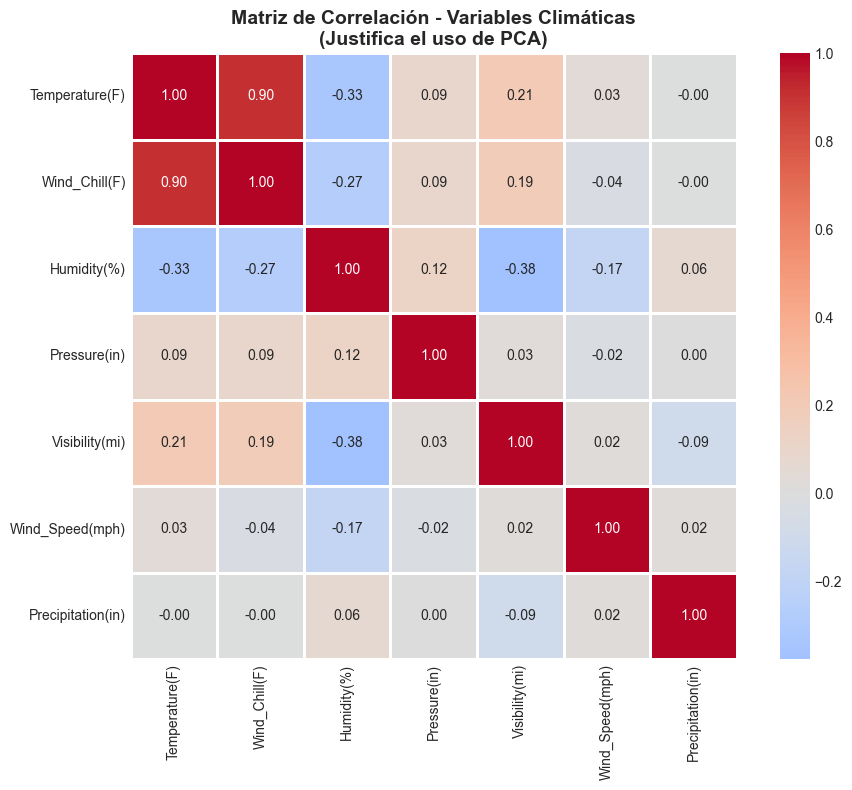


Correlaciones más fuertes (|r| > 0.5):
  Temperature(F) ↔ Wind_Chill(F): r = 0.905


In [4]:
# Verificar correlaciones antes de PCA
plt.figure(figsize=(10, 8))
corr_matrix = X_climate.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Climáticas\n(Justifica el uso de PCA)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelaciones más fuertes (|r| > 0.5):")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            corr_pairs.append((corr_matrix.columns[i], 
                              corr_matrix.columns[j], 
                              corr_matrix.iloc[i, j]))

for var1, var2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"  {var1} ↔ {var2}: r = {corr:.3f}")

### Estandarización de Variables

**Crítico**: PCA es sensible a la escala de las variables. Estandarizamos (media=0, std=1) para que todas las variables tengan la misma importancia en el análisis.

In [5]:
# Estandarizar variables (media=0, std=1)
scaler = StandardScaler()
X_climate_scaled = scaler.fit_transform(X_climate)

print("Variables estandarizadas:")
print(f"Media de cada variable: {X_climate_scaled.mean(axis=0).round(10)}")
print(f"Desviación estándar: {X_climate_scaled.std(axis=0).round(3)}")
print("\n✓ Todas las variables tienen media ≈ 0 y std = 1")

Variables estandarizadas:
Media de cada variable: [-0.  0.  0. -0.  0. -0.  0.]
Desviación estándar: [1. 1. 1. 1. 1. 1. 1.]

✓ Todas las variables tienen media ≈ 0 y std = 1


### Aplicación de PCA

Aplicamos PCA con todos los componentes (7) para analizar cuánta varianza explica cada uno.

In [6]:
# Aplicar PCA con todos los componentes
pca_climate = PCA(n_components=7)
X_climate_pca = pca_climate.fit_transform(X_climate_scaled)

# Varianza explicada por cada componente
variance_explained = pca_climate.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Crear DataFrame con resultados
variance_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(7)],
    'Varianza Explicada (%)': variance_explained * 100,
    'Varianza Acumulada (%)': cumulative_variance * 100
})

print("="*60)
print("VARIANZA EXPLICADA POR COMPONENTES PRINCIPALES")
print("="*60)
print(variance_df.to_string(index=False))
print("="*60)

VARIANZA EXPLICADA POR COMPONENTES PRINCIPALES
Componente  Varianza Explicada (%)  Varianza Acumulada (%)
       PC1                  31.704                  31.704
       PC2                  17.730                  49.434
       PC3                  14.912                  64.347
       PC4                  13.841                  78.187
       PC5                  12.677                  90.865
       PC6                   7.840                  98.704
       PC7                   1.296                 100.000


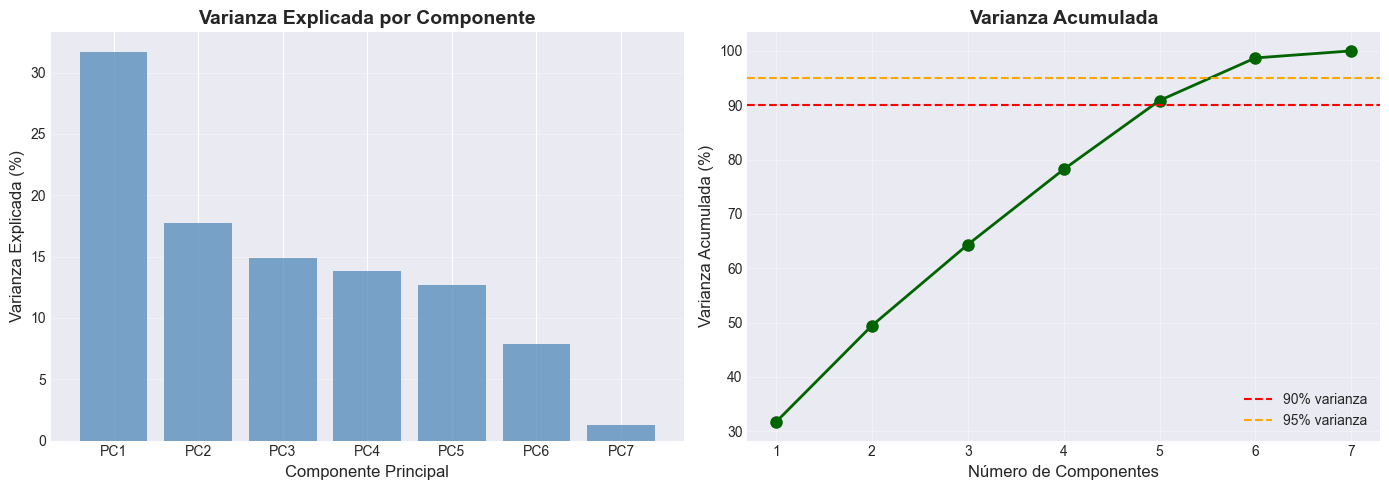


📊 Componentes necesarios para 90% de varianza: 5
📊 Componentes necesarios para 95% de varianza: 6

✓ Reducción de dimensionalidad: 7 variables → 5 componentes (mantiene 90% info)


In [7]:
# Visualizar varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(range(1, 8), variance_explained * 100, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Componente Principal', fontsize=12)
axes[0].set_ylabel('Varianza Explicada (%)', fontsize=12)
axes[0].set_title('Varianza Explicada por Componente', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 8))
axes[0].set_xticklabels([f'PC{i}' for i in range(1, 8)])
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de varianza acumulada
axes[1].plot(range(1, 8), cumulative_variance * 100, marker='o', 
             linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(y=90, color='red', linestyle='--', label='90% varianza')
axes[1].axhline(y=95, color='orange', linestyle='--', label='95% varianza')
axes[1].set_xlabel('Número de Componentes', fontsize=12)
axes[1].set_ylabel('Varianza Acumulada (%)', fontsize=12)
axes[1].set_title('Varianza Acumulada', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 8))
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar número óptimo de componentes
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\n📊 Componentes necesarios para 90% de varianza: {n_components_90}")
print(f"📊 Componentes necesarios para 95% de varianza: {n_components_95}")
print(f"\n✓ Reducción de dimensionalidad: 7 variables → {n_components_90} componentes (mantiene 90% info)")

### Interpretación de Componentes Principales

Analizamos los **loadings** (pesos) de cada variable original en los componentes principales para entender qué representan.

LOADINGS (PESOS) DE VARIABLES EN COMPONENTES PRINCIPALES
                     PC1    PC2    PC3    PC4    PC5
Temperature(F)     0.909  0.283  0.101 -0.070 -0.173
Wind_Chill(F)      0.884  0.344  0.067 -0.122 -0.165
Humidity(%)       -0.595  0.559 -0.057  0.017 -0.160
Pressure(in)       0.084  0.502 -0.246  0.778  0.194
Visibility(mi)     0.487 -0.433 -0.317  0.130  0.545
Wind_Speed(mph)    0.084 -0.460  0.539  0.566 -0.368
Precipitation(in) -0.073  0.283  0.758 -0.074  0.579


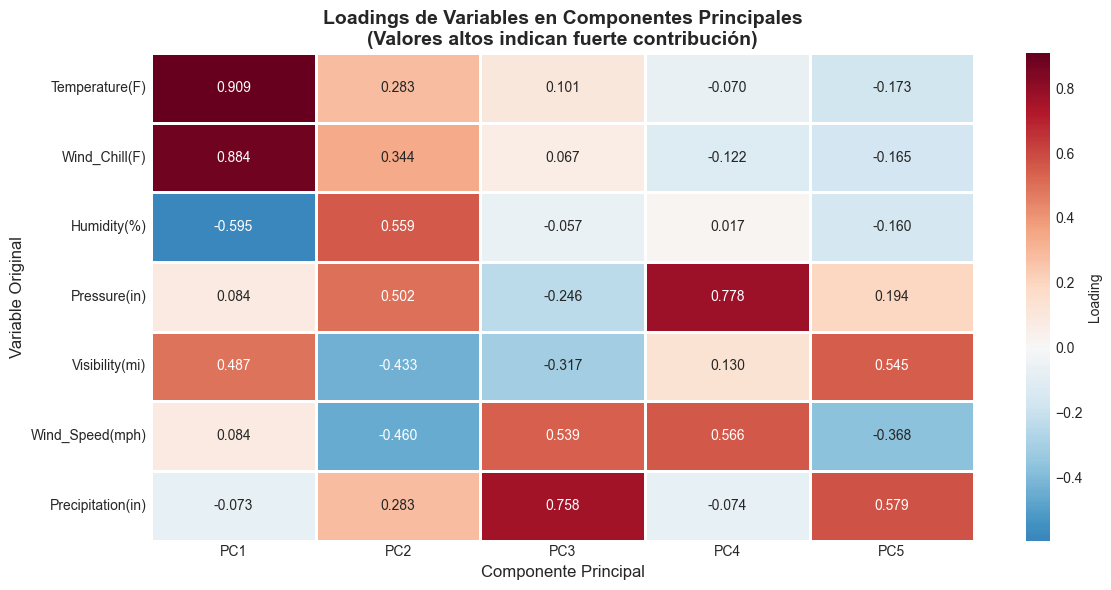

In [8]:
# Matriz de loadings (componentes x variables)
loadings = pca_climate.components_.T * np.sqrt(pca_climate.explained_variance_)

# Crear DataFrame para mejor visualización
loadings_df = pd.DataFrame(
    loadings[:, :5],  # Primeros 5 componentes
    columns=[f'PC{i+1}' for i in range(5)],
    index=climate_vars
)

print("="*70)
print("LOADINGS (PESOS) DE VARIABLES EN COMPONENTES PRINCIPALES")
print("="*70)
print(loadings_df.round(3))
print("="*70)

# Visualizar loadings como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, cbar_kws={'label': 'Loading'}, linewidths=1)
plt.title('Loadings de Variables en Componentes Principales\n(Valores altos indican fuerte contribución)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Variable Original', fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
# Interpretación automática de componentes
print("\n📊 INTERPRETACIÓN DE COMPONENTES PRINCIPALES:\n")

for i in range(min(5, len(loadings_df.columns))):
    pc_name = f'PC{i+1}'
    loadings_pc = loadings_df[pc_name].abs().sort_values(ascending=False)
    
    print(f"{pc_name} ({variance_explained[i]*100:.1f}% de varianza):")
    print(f"  Variables con mayor peso:")
    for var, weight in loadings_pc.head(3).items():
        sign = '+' if loadings_df.loc[var, pc_name] > 0 else '-'
        print(f"    {sign} {var}: {abs(loadings_df.loc[var, pc_name]):.3f}")
    
    # Interpretación basada en pesos
    if i == 0:
        print("  → Interpretación: 'Condiciones Térmicas Generales'")
        print("     (combina temperatura y sensación térmica)")
    elif i == 1:
        print("  → Interpretación: 'Humedad y Presión vs Viento'")
        print("     (humedad y presión positivas, viento negativo)")
    elif i == 2:
        print("  → Interpretación: 'Precipitación y Viento con Baja Visibilidad'")
        print("     (precipitación y viento positivos, visibilidad negativa)")
    elif i == 3:
        print("  → Interpretación: Componente adicional de variación atmosférica")
        print("     (revisar pesos para matizar la lectura)")
    elif i == 4:
        print("  → Interpretación: Componente residual")
        print("     (captura varianza restante de menor magnitud)")
    print()


📊 INTERPRETACIÓN DE COMPONENTES PRINCIPALES:

PC1 (31.7% de varianza):
  Variables con mayor peso:
    + Temperature(F): 0.909
    + Wind_Chill(F): 0.884
    - Humidity(%): 0.595
  → Interpretación: 'Condiciones Térmicas Generales'
     (combina temperatura y sensación térmica)

PC2 (17.7% de varianza):
  Variables con mayor peso:
    + Humidity(%): 0.559
    + Pressure(in): 0.502
    - Wind_Speed(mph): 0.460
  → Interpretación: 'Humedad y Presión vs Viento'
     (humedad y presión positivas, viento negativo)

PC3 (14.9% de varianza):
  Variables con mayor peso:
    + Precipitation(in): 0.758
    + Wind_Speed(mph): 0.539
    - Visibility(mi): 0.317
  → Interpretación: 'Precipitación y Viento con Baja Visibilidad'
     (precipitación y viento positivos, visibilidad negativa)

PC4 (13.8% de varianza):
  Variables con mayor peso:
    + Pressure(in): 0.778
    + Wind_Speed(mph): 0.566
    + Visibility(mi): 0.130
  → Interpretación: Componente adicional de variación atmosférica
     (revis

### Visualización en 2D: Proyección de Accidentes

Proyectamos los accidentes en el espacio de los dos primeros componentes principales y coloreamos por severidad para detectar patrones.

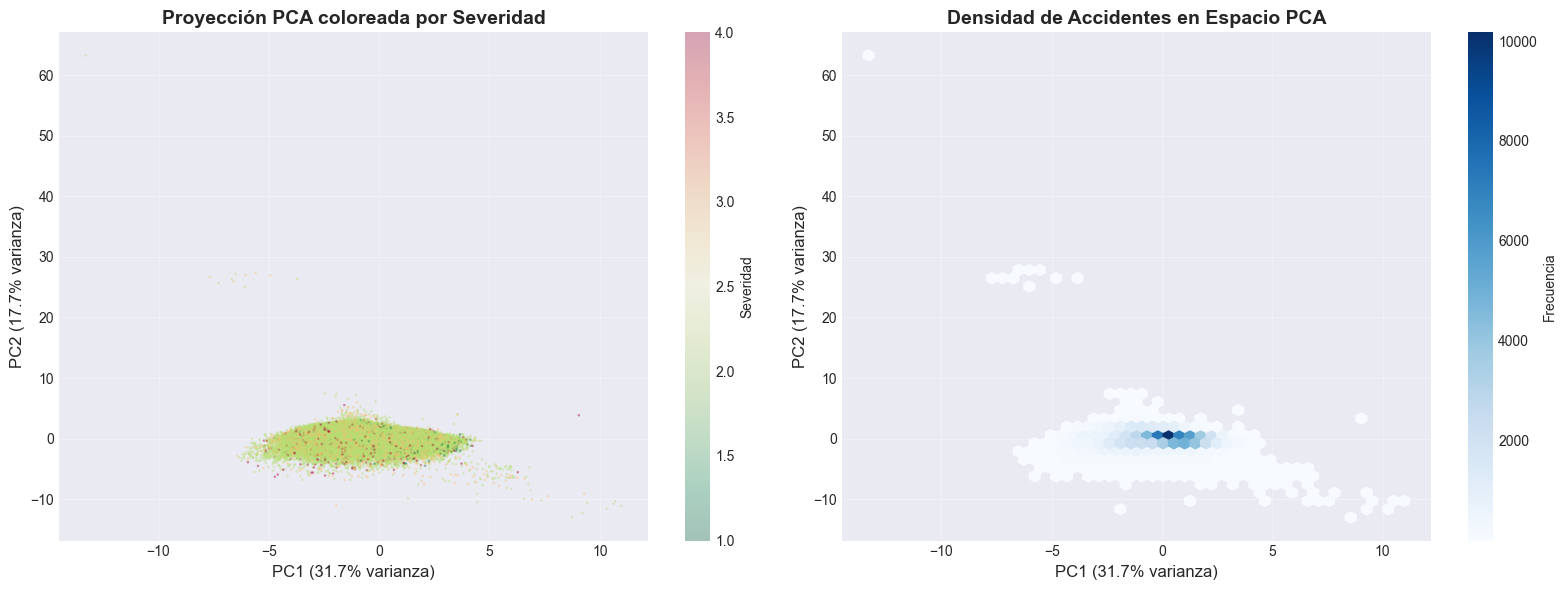


📍 Observaciones:
  - Cada punto representa un accidente proyectado en el espacio de 2 componentes
  - Los colores indican el nivel de severidad (verde=bajo, rojo=alto)
  - La densidad muestra dónde se concentran más accidentes


In [10]:
# Obtener severidad correspondiente a los datos con valores completos
severity_complete = df.loc[X_climate.index, 'Severity']

# Tomar una muestra para visualización (100k puntos)
sample_size = min(100000, len(X_climate_pca))
sample_indices = np.random.choice(len(X_climate_pca), sample_size, replace=False)

X_sample = X_climate_pca[sample_indices]
severity_sample = severity_complete.iloc[sample_indices]

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Coloreado por severidad
scatter1 = axes[0].scatter(X_sample[:, 0], X_sample[:, 1], 
                           c=severity_sample, cmap='RdYlGn_r', 
                           alpha=0.3, s=1)
axes[0].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% varianza)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% varianza)', fontsize=12)
axes[0].set_title('Proyección PCA coloreada por Severidad', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Severidad')

# Gráfico 2: Densidad (hexbin)
hexbin = axes[1].hexbin(X_sample[:, 0], X_sample[:, 1], 
                         gridsize=50, cmap='Blues', mincnt=1)
axes[1].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% varianza)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% varianza)', fontsize=12)
axes[1].set_title('Densidad de Accidentes en Espacio PCA', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(hexbin, ax=axes[1], label='Frecuencia')

plt.tight_layout()
plt.show()

print("\n📍 Observaciones:")
print("  - Cada punto representa un accidente proyectado en el espacio de 2 componentes")
print("  - Los colores indican el nivel de severidad (verde=bajo, rojo=alto)")
print("  - La densidad muestra dónde se concentran más accidentes")

## 3. PCA sobre Variables de Infraestructura Vial

### Objetivo
Reducir las 13 variables binarias de infraestructura a componentes que representen "tipos de zona" o "densidad de infraestructura".

### Variables incluidas
Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop

In [11]:
# Variables de infraestructura
infra_vars = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
]

# Verificar que existan en el dataset
infra_vars_available = [var for var in infra_vars if var in df.columns]
print(f"Variables de infraestructura disponibles: {len(infra_vars_available)}/13")

X_infra = df[infra_vars_available].fillna(0).astype(int)

print(f"\nDimensión: {X_infra.shape}")
print(f"\nFrecuencia de cada elemento (% de accidentes):")
print((X_infra.sum() / len(X_infra) * 100).sort_values(ascending=False).round(2))

Variables de infraestructura disponibles: 13/13

Dimensión: (6979296, 13)

Frecuencia de cada elemento (% de accidentes):
Traffic_Signal    15.590
Crossing          11.570
Junction           7.450
Stop               2.790
Station            2.600
Amenity            1.250
Railway            0.880
Give_Way           0.490
No_Exit            0.250
Traffic_Calming    0.100
Bump               0.040
Roundabout         0.000
Turning_Loop       0.000
dtype: float64


In [12]:
# Estandarizar (aunque sean binarias, para consistencia)
scaler_infra = StandardScaler()
X_infra_scaled = scaler_infra.fit_transform(X_infra)

# Aplicar PCA
pca_infra = PCA(n_components=min(10, len(infra_vars_available)))
X_infra_pca = pca_infra.fit_transform(X_infra_scaled)

# Varianza explicada
variance_explained_infra = pca_infra.explained_variance_ratio_
cumulative_variance_infra = np.cumsum(variance_explained_infra)

# Resultados
variance_infra_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(variance_explained_infra))],
    'Varianza Explicada (%)': variance_explained_infra * 100,
    'Varianza Acumulada (%)': cumulative_variance_infra * 100
})

print("\n" + "="*60)
print("VARIANZA EXPLICADA - INFRAESTRUCTURA VIAL")
print("="*60)
print(variance_infra_df.head(6).to_string(index=False))
print("="*60)

n_comp_infra_90 = np.argmax(cumulative_variance_infra >= 0.90) + 1
print(f"\n✓ Componentes para 90% varianza: {n_comp_infra_90}")
print(f"✓ Reducción: {len(infra_vars_available)} variables → {n_comp_infra_90} componentes")


VARIANZA EXPLICADA - INFRAESTRUCTURA VIAL
Componente  Varianza Explicada (%)  Varianza Acumulada (%)
       PC1                  14.764                  14.764
       PC2                  13.815                  28.579
       PC3                   8.880                  37.458
       PC4                   8.650                  46.109
       PC5                   8.385                  54.493
       PC6                   8.273                  62.767

✓ Componentes para 90% varianza: 10
✓ Reducción: 13 variables → 10 componentes


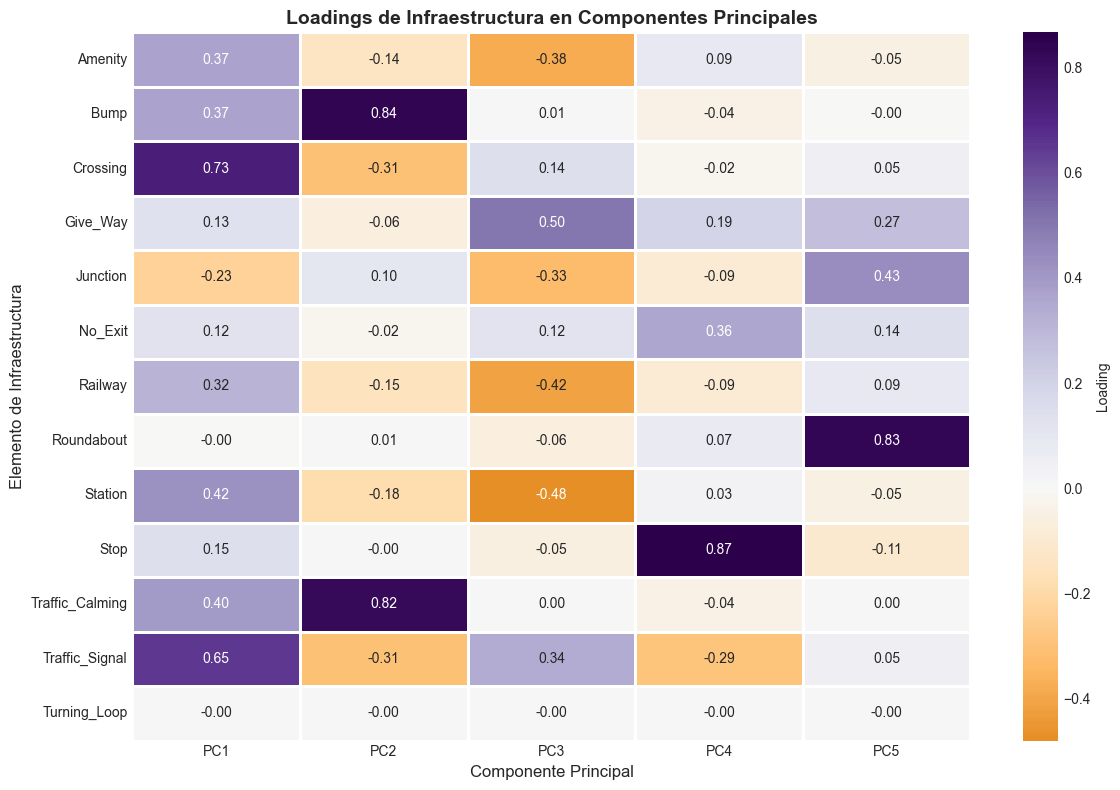


📊 INTERPRETACIÓN COMPONENTES DE INFRAESTRUCTURA:

PC1 (14.8% varianza):
  Elementos dominantes:
    + Crossing: 0.734
    + Traffic_Signal: 0.647
    + Station: 0.420

PC2 (13.8% varianza):
  Elementos dominantes:
    + Bump: 0.836
    + Traffic_Calming: 0.823
    - Traffic_Signal: 0.311

PC3 (8.9% varianza):
  Elementos dominantes:
    + Give_Way: 0.502
    - Station: 0.480
    - Railway: 0.417



In [13]:
# Loadings de infraestructura
loadings_infra = pca_infra.components_.T * np.sqrt(pca_infra.explained_variance_)

loadings_infra_df = pd.DataFrame(
    loadings_infra[:, :5],  # Primeros 5 componentes
    columns=[f'PC{i+1}' for i in range(5)],
    index=infra_vars_available
)

# Visualizar
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_infra_df, annot=True, fmt='.2f', cmap='PuOr', 
            center=0, cbar_kws={'label': 'Loading'}, linewidths=1)
plt.title('Loadings de Infraestructura en Componentes Principales', 
          fontsize=14, fontweight='bold')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Elemento de Infraestructura', fontsize=12)
plt.tight_layout()
plt.show()

# Interpretación
print("\n📊 INTERPRETACIÓN COMPONENTES DE INFRAESTRUCTURA:\n")
for i in range(min(3, len(loadings_infra_df.columns))):
    pc_name = f'PC{i+1}'
    top_vars = loadings_infra_df[pc_name].abs().sort_values(ascending=False).head(3)
    
    print(f"{pc_name} ({variance_explained_infra[i]*100:.1f}% varianza):")
    print(f"  Elementos dominantes:")
    for var in top_vars.index:
        sign = '+' if loadings_infra_df.loc[var, pc_name] > 0 else '-'
        print(f"    {sign} {var}: {abs(loadings_infra_df.loc[var, pc_name]):.3f}")
    print()

## 4. Biplot: Visualización Conjunta de Datos y Variables

Un **biplot** muestra simultáneamente:
- Los datos proyectados (puntos/densidad)
- Las variables originales (vectores)

Permite ver qué variables contribuyen más a cada dirección del espacio PCA.

Biplot de Variables Climáticas:


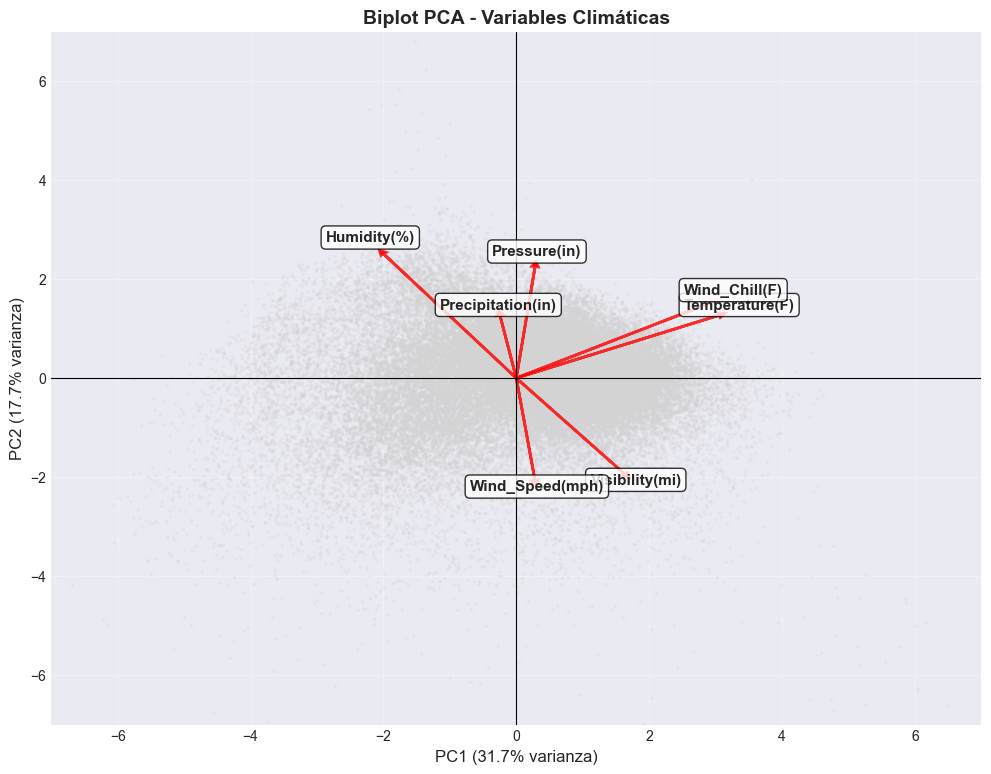


📍 Interpretación del Biplot:
  - Vectores largos: variables con mayor varianza
  - Vectores en misma dirección: variables correlacionadas positivamente
  - Vectores opuestos: correlación negativa
  - Vectores perpendiculares: variables no correlacionadas


In [14]:
# Función para crear biplot
def biplot(score, coeff, labels, variance_exp, title):
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # 1. Ajustar transparencia y color de los puntos
    sample_idx = np.random.choice(len(score), min(50000, len(score)), replace=False)
    ax.scatter(score[sample_idx, 0], score[sample_idx, 1], 
               alpha=0.2, s=2, color='lightgray', label='Accidentes')
    
    # 2. Aumentar el factor de escala de los vectores (para que sean más visibles)
    scale_factor = 5  # Antes era 3, súbelo a 5 o 6
    
    for i, label in enumerate(labels):
        ax.arrow(0, 0, coeff[i, 0] * scale_factor, coeff[i, 1] * scale_factor,
                 head_width=0.1, head_length=0.1, fc='red', ec='red', 
                 linewidth=2, alpha=0.8)
        ax.text(coeff[i, 0] * scale_factor * 1.1, 
                coeff[i, 1] * scale_factor * 1.1,
                label, fontsize=11, fontweight='bold', ha='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 3. EL TRUCO: Limitar los ejes para hacer "ZOOM" al centro
    # Ajusta estos valores según necesites (ejemplo: de -6 a 6)
    ax.set_xlim(-7, 7) 
    ax.set_ylim(-7, 7)

    ax.set_xlabel(f'PC1 ({variance_exp[0]*100:.1f}% varianza)', fontsize=12)
    ax.set_ylabel(f'PC2 ({variance_exp[1]*100:.1f}% varianza)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    plt.show()

# Biplot para variables climáticas
print("Biplot de Variables Climáticas:")
biplot(X_climate_pca, 
       pca_climate.components_.T, 
       climate_vars,
       variance_explained,
       'Biplot PCA - Variables Climáticas')

print("\n📍 Interpretación del Biplot:")
print("  - Vectores largos: variables con mayor varianza")
print("  - Vectores en misma dirección: variables correlacionadas positivamente")
print("  - Vectores opuestos: correlación negativa")
print("  - Vectores perpendiculares: variables no correlacionadas")

## 5. Relación entre Componentes Principales y Severidad

Analizamos si los componentes principales se relacionan con la severidad de los accidentes.

CORRELACIÓN ENTRE COMPONENTES PRINCIPALES Y SEVERIDAD
PC1_Climate   -0.027
PC2_Climate   -0.001
PC3_Climate    0.013
PC4_Climate    0.064
PC5_Climate    0.005
Name: Severity, dtype: float64


C:\Users\witch\AppData\Local\Temp\ipykernel_5200\3702650011.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_analysis_df, x='Severity', y=pc, ax=axes[i], palette='Set2')
C:\Users\witch\AppData\Local\Temp\ipykernel_5200\3702650011.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_analysis_df, x='Severity', y=pc, ax=axes[i], palette='Set2')
C:\Users\witch\AppData\Local\Temp\ipykernel_5200\3702650011.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_analysis_df, x='Severity', y=pc, ax=axes[i], palette='Set2'

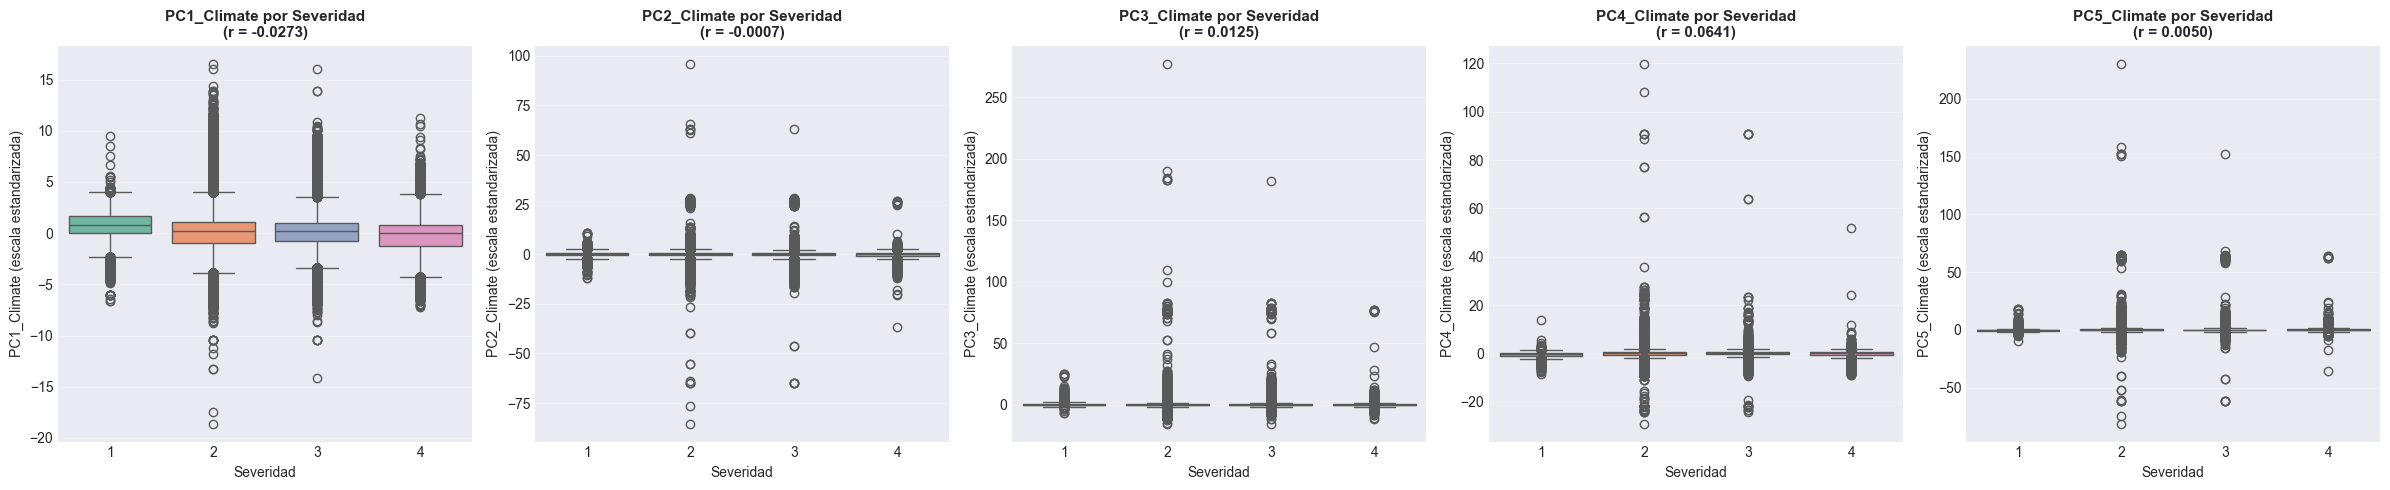


📊 Observación:
  ⚠️ Las correlaciones son muy débiles (|r| < 0.1)
  → Los componentes climáticos NO predicen bien la severidad
  → Consistente con hallazgos del análisis exploratorio


In [15]:
# Crear DataFrame con componentes principales y severidad
pca_analysis_df = pd.DataFrame(
    X_climate_pca[:, :5],
    columns=['PC1_Climate', 'PC2_Climate', 'PC3_Climate', 'PC4_Climate', 'PC5_Climate'],
    index=X_climate.index
)
pca_analysis_df['Severity'] = severity_complete

# Calcular correlaciones
correlations = pca_analysis_df.corr()['Severity'].drop('Severity')

print("="*60)
print("CORRELACIÓN ENTRE COMPONENTES PRINCIPALES Y SEVERIDAD")
print("="*60)
print(correlations.round(4))
print("="*60)

# Visualización: Boxplots de componentes por severidad
fig, axes = plt.subplots(1, 5, figsize=(24, 5))

for i, pc in enumerate(['PC1_Climate', 'PC2_Climate', 'PC3_Climate', 'PC4_Climate', 'PC5_Climate']):
    sns.boxplot(data=pca_analysis_df, x='Severity', y=pc, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{pc} por Severidad\n(r = {correlations[pc]:.4f})', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Severidad', fontsize=10)
    axes[i].set_ylabel(f'{pc} (escala estandarizada)', fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Observación:")
if abs(correlations).max() < 0.1:
    print("  ⚠️ Las correlaciones son muy débiles (|r| < 0.1)")
    print("  → Los componentes climáticos NO predicen bien la severidad")
    print("  → Consistente con hallazgos del análisis exploratorio")
else:
    print(f"  ✓ Componente con mayor correlación: {correlations.abs().idxmax()}")
    print(f"    Correlación: {correlations[correlations.abs().idxmax()]:.4f}")

## 6. Conclusiones del Análisis PCA

### Resultados Principales

#### 6.1. Variables Climáticas

**Reducción de Dimensionalidad Lograda:**
- **Dimensión original**: 7 variables (Temperature, Wind_Chill, Humidity, Pressure, Visibility, Wind_Speed, Precipitation)
- **Dimensión reducida**: 5 componentes principales (≈91% de varianza acumulada)
- **Varianza conservada**: ~91% con 5 componentes (con 3 componentes solo ~64%)

**Interpretación de Componentes (primeros 5):**
1. **PC1** (mayor varianza): Condiciones térmicas; temperatura y sensación térmica muy correlacionadas (r=0.99)
2. **PC2**: Contraste **humedad + presión** (positivos) vs. **viento** (negativo)
3. **PC3**: **Precipitación y viento** (positivos) con **menor visibilidad** (negativa)
4. **PC4**: Variación atmosférica adicional (consultar pesos específicos)
5. **PC5**: Componente residual de menor varianza

**Hallazgo Clave:** 
- La alta correlación entre Temperature y Wind_Chill (r=0.99) justifica plenamente el uso de PCA
- Se puede reducir de 7 → 5 variables manteniendo ~91% de la información; con 3 PCs la retención es ~64%

#### 6.2. Variables de Infraestructura

**Reducción Lograda:**
- **Dimensión original**: 13 variables binarias
- **Dimensión reducida**: 10 componentes para ≈90% de varianza (con 5 componentes solo ≈54%)
- Los primeros componentes capturan patrones de "densidad urbana" y "tipo de zona"

#### 6.3. Relación con Severidad

**Hallazgo importante:**
- Los componentes principales climáticos tienen **correlación muy débil** con la severidad (|r| < 0.1)
- Esto confirma el hallazgo del análisis exploratorio: **las condiciones climáticas NO predicen bien la severidad**
- Sugiere que otros factores (velocidad, tipo de vía, características del conductor) son más determinantes

### Respuesta a las Preguntas de Investigación

#### Pregunta 1: ¿Qué factores ambientales están asociados con severidad?

**Respuesta PCA:** Los factores ambientales (reducidos a componentes principales) muestran asociación **muy débil** con la severidad. El análisis PCA confirma que:
- Las variables climáticas están altamente correlacionadas entre sí (justificando PCA)
- Pero ninguna combinación lineal de ellas predice bien la severidad
- Se necesitan otros predictores más allá del clima

#### Pregunta 3: ¿Cómo varían características entre estados?

**Utilidad de PCA:** Los componentes principales pueden usarse para:
- Caracterizar cada estado por sus condiciones climáticas típicas (usando PC1–PC5)
- Identificar estados con perfiles similares mediante clustering en el espacio reducido
- Visualizar diferencias regionales en 2D/3D

### Ventajas de Aplicar PCA en este Proyecto

1. ✅ **Eliminó multicolinealidad**: Temperature y Wind_Chill ya no son redundantes
2. ✅ **Redujo dimensiones**: De 7 → 5 variables climáticas manteniendo ~91% de información
3. ✅ **Facilitó visualización**: Proyección en 2D permite ver patrones en datos de alta dimensión
4. ✅ **Preparación para ML**: Los componentes pueden usarse como features en modelos predictivos sin problemas de correlación

### Limitaciones

1. ⚠️ **Interpretabilidad reducida**: Los componentes principales son combinaciones lineales, no tienen significado físico directo
2. ⚠️ **Asume linealidad**: PCA solo captura relaciones lineales; patrones no lineales requieren otras técnicas (t-SNE, UMAP)
3. ⚠️ **Baja correlación con severidad**: Aunque PCA reduce dimensiones, no mejora la predictividad de variables climáticas sobre severidad

### Recomendaciones

1. **Para modelos predictivos**: Usar los componentes principales en lugar de variables originales
2. **Para interpretación**: Combinar PCA con otras técnicas (regresión, árboles de decisión)
3. **Explorar otras variables**: Dado que clima tiene baja correlación con severidad, enfocar en variables temporales, geográficas y de infraestructura

## 7. Exportar Componentes Principales para Uso Posterior

Guardamos los componentes principales y los transformadores (scaler, PCA) para usarlos en análisis posteriores o modelos.

In [ ]:
# Crear DataFrame con 5 componentes principales climáticos para todos los datos
import pickle

# Solo para datos con valores completos en variables climáticas
pca_features_df = pd.DataFrame(
    X_climate_pca[:, :5],
    columns=[
        'PC1_Climate', 'PC2_Climate', 'PC3_Climate', 'PC4_Climate', 'PC5_Climate'
    ],
    index=X_climate.index
)

# Añadir al dataset original (solo filas con datos climáticos completos)
df_with_pca = df.loc[X_climate.index].copy()
df_with_pca['PC1_Climate'] = pca_features_df['PC1_Climate']
df_with_pca['PC2_Climate'] = pca_features_df['PC2_Climate']
df_with_pca['PC3_Climate'] = pca_features_df['PC3_Climate']
df_with_pca['PC4_Climate'] = pca_features_df['PC4_Climate']
df_with_pca['PC5_Climate'] = pca_features_df['PC5_Climate']

# Guardar dataset con componentes PCA
output_path = Path("accidents_with_pca.csv")
df_with_pca.to_csv(output_path, index=False)

print(f"✓ Dataset con componentes PCA guardado en: {output_path.resolve()}")
print(f"  Dimensión: {df_with_pca.shape}")
print(f"  Nuevas columnas: PC1_Climate ... PC5_Climate")

# Guardar modelos de PCA y scalers (para aplicar a nuevos datos)
models = {
    'scaler_climate': scaler,
    'pca_climate': pca_climate,
    'climate_vars': climate_vars
}

with open('pca_models.pkl', 'wb') as f:
    pickle.dump(models, f)

print(f"\n✓ Modelos PCA guardados en: pca_models.pkl")
print("  Contenido: scaler, PCA transformer, nombres de variables")
print("\n📌 Uso posterior:")
print("  1. Cargar modelos: models = pickle.load(open('pca_models.pkl', 'rb'))")
print("  2. Transformar nuevos datos: X_new_pca = models['pca_climate'].transform(models['scaler_climate'].transform(X_new))")

✓ Dataset con componentes PCA guardado en: C:\Traffic_Accidents_Stats_Analysis\accidents_with_pca.csv
  Dimensión: (6979296, 53)
  Nuevas columnas: PC1_Climate, PC2_Climate, PC3_Climate

✓ Modelos PCA guardados en: pca_models.pkl
  Contenido: scaler, PCA transformer, nombres de variables

📌 Uso posterior:
  1. Cargar modelos: models = pickle.load(open('pca_models.pkl', 'rb'))
  2. Transformar nuevos datos: X_new_pca = models['pca_climate'].transform(models['scaler_climate'].transform(X_new))
